# Regression With Tensorflow (House Prices)
Let's predict some house prices

In [1]:
from __future__ import absolute_import, division, print_function

%matplotlib inline

import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import datetime

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow import keras

## TF-GPU Debug
The following block tests if TF is running on GPU.

In [2]:
## This block is to tweak TF running on GPU
## You may comment this out, if you are not using GPU

## ---- start Memory setting ----
## Ask TF not to allocate all GPU memory at once.. allocate as needed
## Without this the execution will fail with "failed to initialize algorithm" error

from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)
## ---- end Memory setting ----


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



## Step 1 : Read Data

In [3]:
data_location = '../data/house-prices/house-sales-full.csv'
# data_location = 'https://elephantscale-public.s3.amazonaws.com/data/house-prices/house-sales-full.csv'

house_prices = pd.read_csv(data_location)
house_prices

,DocumentID,Date,SalePrice,PropertyID,PropertyType,ym,zhvi_px,zhvi_idx,AdjSalePrice,NbrLivingUnits,...,Bathrooms,Bedrooms,BldgGrade,YrBuilt,YrRenovated,TrafficNoise,LandVal,ImpsVal,ZipCode,NewConstruction
0,1,9/16/14,280000,1000102,Multiplex,9/1/14,405100,0.930836,300805.0,2,...,3.00,6,7,1991,0,0,70000,229000,98002,False
1,2,6/16/06,1000000,1200013,Single Family,6/1/06,404400,0.929228,1076162.0,1,...,3.75,4,10,2005,0,0,203000,590000,98166,True
2,3,1/29/07,745000,1200019,Single Family,1/1/07,425600,0.977941,761805.0,1,...,1.75,4,8,1947,0,0,183000,275000,98166,False
3,4,2/25/08,425000,2800016,Single Family,2/1/08,418400,0.961397,442065.0,1,...,3.75,5,7,1966,0,0,104000,229000,98168,False
4,5,3/29/13,240000,2800024,Single Family,3/1/13,351600,0.807904,297065.0,1,...,1.75,4,7,1948,0,0,104000,205000,98168,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27058,27059,10/31/12,374000,9895000030,Townhouse,10/1/12,332400,0.763787,489665.0,1,...,1.75,2,9,2011,0,0,147000,269000,-1,False
27059,27060,12/7/12,374000,9895000040,Townhouse,12/1/12,339400,0.779871,479566.0,1,...,1.75,2,9,2011,0,0,147000,269000,-1,True
27060,27061,7/9/12,165000,9899200010,Single Family,7/1/12,325300,0.747472,220744.0,1,...,1.00,4,6,1971,0,0,92000,130000,98055,False
27061,27062,5/26/06,315000,9900000355,Single Family,5/1/06,400600,0.920496,342207.0,1,...,2.00,3,7,1939,0,0,103000,212000,98166,False


## Step 2 : Cleanup Data

In [4]:
print("original row count : ", house_prices.shape)
house_prices = house_prices.dropna()
print ("cleaned up row count : ", house_prices.shape)

original row count :  (27063, 23)
cleaned up row count :  (27063, 23)


## Step 3 : Exploratory Data Analysis (EDA)
EDA will give us a sense of data.  It is highly recommended that you do this before learning.

**==> Q : What is max number of bedrooms? :-)**

In [5]:
## get a summary of data
pd.options.display.float_format = '{:,.2f}'.format
house_prices.describe().T

,count,mean,std,min,25%,50%,75%,max
DocumentID,"27,063.00","13,532.00","7,812.56",1.00,"6,766.50","13,532.00","20,297.50","27,063.00"
SalePrice,"27,063.00","511,626.20","342,821.17","3,000.00","329,000.00","425,000.00","590,000.00","11,000,000.00"
PropertyID,"27,063.00","4,680,324,882.08","2,896,350,979.15","1,000,102.00","2,213,000,057.50","3,972,900,140.00","7,504,001,385.00","9,906,000,035.00"
zhvi_px,"27,063.00","390,750.58","37,024.46","311,600.00","357,100.00","400,600.00","421,200.00","435,200.00"
zhvi_idx,"27,063.00",0.90,0.09,0.72,0.82,0.92,0.97,1.00
AdjSalePrice,"27,063.00","570,918.76","380,236.63","3,368.00","366,918.50","475,664.00","655,061.00","11,644,855.00"
NbrLivingUnits,"27,063.00",1.02,0.15,1.00,1.00,1.00,1.00,5.00
SqFtLot,"27,063.00","10,997.68","28,110.66",494.00,"4,257.50","6,636.00","9,450.00","1,024,068.00"
SqFtTotLiving,"27,063.00","2,122.96",939.84,370.00,"1,440.00","1,940.00","2,610.00","10,740.00"
SqFtFinBasement,"27,063.00",275.30,428.71,0.00,0.00,0.00,510.00,"3,500.00"


## Step 4: Remove Outliers
As you can see we have a few outliers.  
Let's remove them by considering only houses with less than 5 BR

In [6]:
## TODO : commented out for now, 
##        uncomment during tuning phase

# house_prices = house_prices[house_prices['Bedrooms'] <= 5]
# house_prices

## Step 5 : Choose Columns to consider
Which attributes do you think are important in deciding SalePrice?

In [7]:
## TODO : Experiment with this, 
## select columns you think are important in determining SalePrice
input_columns = ['Bedrooms', 'Bathrooms', 'SqFtTotLiving', 'SqFtLot']
label_column = 'SalePrice'
# x = house_prices.loc[:, input_columns]
x = house_prices [input_columns]
y = house_prices[[label_column]]

print(x.head())
print ('--------')
print (y.head())

   Bedrooms  Bathrooms  SqFtTotLiving  SqFtLot
0         6       3.00           2400     9373
1         4       3.75           3764    20156
2         4       1.75           2060    26036
3         5       3.75           3200     8618
4         4       1.75           1720     8620
--------
   SalePrice
0     280000
1    1000000
2     745000
3     425000
4     240000


## Step 6 :  Split data into train /test

In [8]:
from sklearn.model_selection import train_test_split

## split train/test = 80% / 20%
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

# backup
x_train_bak = x_train.copy(deep=True)
x_test_bak = x_test.copy(deep=True)

print ("x_train.shape : ", x_train.shape)
print ("y_train.shape : ", y_train.shape)
print ("x_test.shape : ", x_test.shape)
print ("y_test.shape : ", y_test.shape)

x_train.shape :  (21650, 4)
y_train.shape :  (21650, 1)
x_test.shape :  (5413, 4)
y_test.shape :  (5413, 1)


## Step 7 : Scale Data

In [9]:
## To turn off scaling, comment this cell out

# def my_scaler(df):
#     #return (df-df.min())/(df.max()-df.min())  ## this is min/max scaler
#     return (df - df.mean()) / df.std()

# print ("x_train: before and after")
# print(x_train_bak.head())
# x_train = my_scaler(x_train_bak)
# print(x_train.head())

# print ('=====')
# print ('x_test: before / after')
# print (x_test_bak.head())
# x_test = my_scaler (x_test_bak)
# print (x_test.head())

In [10]:
# Normalize the input features using the sklearn StandardScaler.
# This will set the mean to 0 and standard deviation to 1.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train[x_train.columns] = scaler.fit_transform(x_train[x_train.columns])
x_test[x_test.columns] = scaler.fit_transform(x_test[x_test.columns])

print ("x_train: before and after")
print(x_train_bak.head())
print('----')
print(x_train.head())

print ('======')
print ('x_test: before / after')
print (x_test_bak.head())
print('---')
print (x_test.head())

x_train: before and after
       Bedrooms  Bathrooms  SqFtTotLiving  SqFtLot
21225         3       1.75           1500    15600
7990          3       2.00           1640     7250
16579         2       1.00            770     6731
6926          3       1.75           1350     8742
10340         4       2.50           2370    10631
----
       Bedrooms  Bathrooms  SqFtTotLiving  SqFtLot
21225     -0.44      -0.67          -0.67     0.16
7990      -0.44      -0.34          -0.52    -0.13
16579     -1.58      -1.64          -1.44    -0.15
6926      -0.44      -0.67          -0.83    -0.08
10340      0.70       0.31           0.25    -0.01
x_test: before / after
       Bedrooms  Bathrooms  SqFtTotLiving  SqFtLot
6925          3       1.75           1350     8742
10580         5       3.00           2460     9975
13379         3       2.50           2260     5220
1132          2       1.50            830     1034
20942         5       1.75           2040     8040
---
       Bedrooms  Bathroo

/home/sujee/anaconda3/envs/tf2-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/sujee/anaconda3/envs/tf2-gpu/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/sujee/anaconda3/envs/tf2-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

## Step 8:  Build a Model

Build a 3 layer network
- input (64 neurons)
- hidden (64 neurons)
- output (1 neuron)

input_dim :  4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Dense)             (None, 64)                320       
_________________________________________________________________
hidden_2 (Dense)             (None, 64)                4160      
_________________________________________________________________
output_layer (Dense)         (None, 1)                 65        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________
None


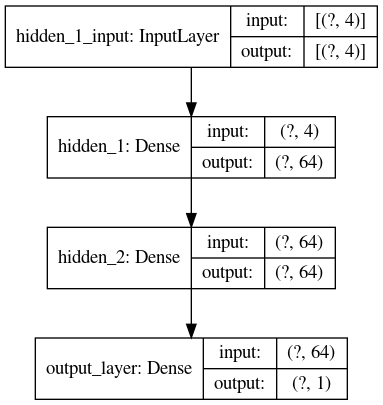

In [11]:
input_dim = len(input_columns)
print ("input_dim : ", input_dim)
model = tf.keras.Sequential([
                # Input layer.. implicitly defined
                tf.keras.layers.Dense(units=64, activation='relu', input_shape=[input_dim], name="hidden_1"),
                tf.keras.layers.Dense(units=64, activation='relu', name="hidden_2"),
                tf.keras.layers.Dense(units=1, activation='linear', name="output_layer")
            ])

optimizer = tf.keras.optimizers.RMSprop(0.01)

model.compile(loss='mean_squared_error',
              optimizer=optimizer,
              metrics=['mean_absolute_error', 'mean_squared_error'])

print (model.summary())

tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

## Step 9: Setup Tensorboard

In [12]:
## This is fairly boiler plate code

import datetime
import os

app_name = 'house-prices-regression' # you can change this, if you like

tb_top_level_dir= '/tmp/tensorboard-logs'
tensorboard_logs_dir= os.path.join (tb_top_level_dir, app_name, 
                                    datetime.datetime.now().strftime("%Y-%m-%d--%H-%M-%S"))
print ("Saving TB logs to : " , tensorboard_logs_dir)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_logs_dir, histogram_freq=1)

# The patience parameter is the amount of epochs to check for improvement
# early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

Saving TB logs to :  /tmp/tensorboard-logs/house-prices-regression/2020-06-19--23-21-01


## Step 10:  Train

In [35]:
%%time

## TODO configure some of these
epochs = 20  ## experiment 100, 500, 1000

print ("training starting ...")
## TODO : to see training output set verbose=2
history = model.fit(
              x_train, y_train,
              epochs=epochs, validation_split = 0.2,
              callbacks=[tensorboard_callback])
#callbacks=[early_stop, tensorboard_callback])

print ("training done.")

training starting ...
Epoch 1/20
542/542 [==============================] - 1s 2ms/step - loss: 52553564160.0000 - mean_absolute_error: 135610.8750 - mean_squared_error: 52553564160.0000 - val_loss: 59276091392.0000 - val_mean_absolute_error: 139423.8594 - val_mean_squared_error: 59276091392.0000
Epoch 2/20
542/542 [==============================] - 1s 2ms/step - loss: 52561502208.0000 - mean_absolute_error: 135418.6719 - mean_squared_error: 52561502208.0000 - val_loss: 59821920256.0000 - val_mean_absolute_error: 138908.9219 - val_mean_squared_error: 59821920256.0000
Epoch 3/20
542/542 [==============================] - 1s 2ms/step - loss: 52546142208.0000 - mean_absolute_error: 135190.7500 - mean_squared_error: 52546142208.0000 - val_loss: 59223592960.0000 - val_mean_absolute_error: 139257.2188 - val_mean_squared_error: 59223592960.0000
Epoch 4/20
542/542 [==============================] - 1s 2ms/step - loss: 52605468672.0000 - mean_absolute_error: 135076.4844 - mean_squared_error: 52

## Step 11: History

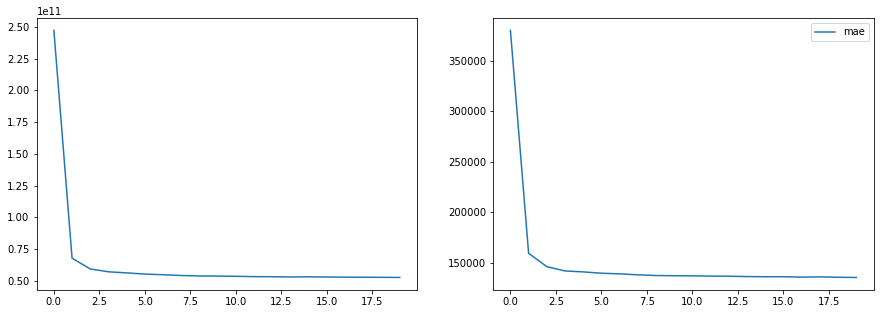

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['mean_squared_error'], label='mse')
plt.subplot(1,2,2)
plt.plot(history.history['mean_absolute_error'], label='mae')
plt.legend()
plt.show()

## Step 12 : Evaluate Model

In [15]:
metric_names = model.metrics_names
print ("model metrics : " , metric_names)
metrics = model.evaluate(x_test, y_test, verbose=0)

for idx, metric in enumerate(metric_names):
    print ("Metric : {} = {:,.2f}".format (metric_names[idx], metrics[idx]))

# print("Testing set - {} : {:,.2f}".format(model.metrics_namesloss))
# print("Testing set Mean Abs Error: {:,.2f}".format(mae))
# print("Testing set Mean Squared Error: {:,.2f}".format(mse))

model metrics :  ['loss', 'mean_absolute_error', 'mean_squared_error']
Metric : loss = 65,617,436,672.00
Metric : mean_absolute_error = 138,742.97
Metric : mean_squared_error = 65,617,436,672.00


## Step 13: Predict

In [16]:
predictions = model.predict(x_test)
print (x_test)
print(predictions)

       Bedrooms  Bathrooms  SqFtTotLiving  SqFtLot
6925      -0.38      -0.61          -0.80    -0.08
10580      1.70       0.98           0.39    -0.03
13379     -0.38       0.34           0.18    -0.21
1132      -1.41      -0.93          -1.35    -0.36
20942      1.70      -0.61          -0.06    -0.10
...         ...        ...            ...      ...
3818       0.66      -0.61          -0.22    -0.22
22803     -0.38       0.66           0.61    -0.03
20370     -0.38       0.34           0.04    -0.31
4536      -0.38       0.34           0.46    -0.26
10743      0.66       0.34           1.03    -0.17

[5413 rows x 4 columns]
[[346975.6 ]
 [507258.9 ]
 [544658.4 ]
 ...
 [517232.06]
 [628732.56]
 [719252.5 ]]


## Step 14: Evalute prediction output
Let's do a pd dataframe and do some plots

In [17]:
predictions_df = pd.DataFrame(x_test_bak)  # use the original one, not scaled
predictions_df['actual_price'] = y_test
predictions_df['predicted_price'] = predictions
predictions_df['error'] = predictions_df['actual_price'] - predictions_df['predicted_price'] 

pd.options.display.float_format = '{:,.2f}'.format
## print sample to see different data every time
predictions_df.sample(frac=0.1)
## or just print the first few
# predictions_df

,Bedrooms,Bathrooms,SqFtTotLiving,SqFtLot,actual_price,predicted_price,error
13542,4,1.00,1440,12870,189950,"349,481.16","-159,531.16"
25521,3,2.75,2720,6700,975000,"716,541.44","258,458.56"
14779,2,1.00,790,9374,199000,"283,468.56","-84,468.56"
11284,5,3.25,2610,3623,524950,"559,292.00","-34,342.00"
27002,4,2.50,2220,4080,50000,"497,811.16","-447,811.16"
...,...,...,...,...,...,...,...
1981,3,2.25,1780,1850,750000,"441,949.38","308,050.62"
7449,4,2.50,2770,8879,1299000,"618,296.06","680,703.94"
13480,2,1.00,910,4400,378000,"311,833.66","66,166.34"
2984,4,1.50,1510,6460,310000,"367,415.50","-57,415.50"


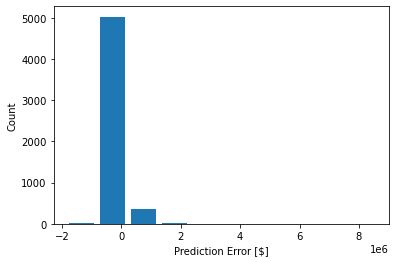

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist (predictions_df['error'], bins=10, rwidth=0.8)
plt.xlabel("Prediction Error [$]")
_ = plt.ylabel("Count")

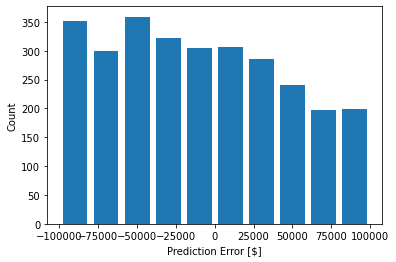

In [19]:
## In the previous plot, outliers are skewing the results
## let's filter out the outliers.
## only consider predictions where the error is less than 100k (chosen randomly)

%matplotlib inline
import matplotlib.pyplot as plt

predictions_df_filtered = predictions_df[predictions_df['error'].abs() < 100000]

plt.hist (predictions_df_filtered['error'], bins=10, rwidth=0.8)
plt.xlabel("Prediction Error [$]")
_ = plt.ylabel("Count")

In [20]:
## which house we got really wrong?
print ("biggest error : ")
predictions_df.loc[predictions_df['error'].abs().idxmax()]


biggest error : 


Bedrooms                   6.00
Bathrooms                  6.50
SqFtTotLiving          7,560.00
SqFtLot               44,000.00
actual_price      11,000,000.00
predicted_price    2,413,255.00
error              8,586,745.00
Name: 20114, dtype: float64

In [21]:
## which house we are spot on?
print ("lowest error")
predictions_df.loc[predictions_df['error'].abs().idxmin()]

lowest error


Bedrooms                3.00
Bathrooms               1.75
SqFtTotLiving         910.00
SqFtLot             7,440.00
actual_price      285,000.00
predicted_price   285,019.31
error                 -19.31
Name: 16929, dtype: float64

### How many house sales, we predicted within 5% ?
Let's use 5% margin of error as our benchmark

In [22]:
predictions_df['error_percentage'] = predictions_df['error'].abs() * 100 / predictions_df['actual_price']
predictions_df

,Bedrooms,Bathrooms,SqFtTotLiving,SqFtLot,actual_price,predicted_price,error,error_percentage
6925,3,1.75,1350,8742,373300,"346,975.59","26,324.41",7.05
10580,5,3.00,2460,9975,450000,"507,258.91","-57,258.91",12.72
13379,3,2.50,2260,5220,485000,"544,658.38","-59,658.38",12.30
1132,2,1.50,830,1034,219950,"302,330.06","-82,380.06",37.45
20942,5,1.75,2040,8040,310000,"429,716.62","-119,716.62",38.62
...,...,...,...,...,...,...,...,...
3818,4,1.75,1890,4800,489200,"429,827.38","59,372.62",12.14
22803,3,2.75,2660,10004,450000,"692,464.50","-242,464.50",53.88
20370,3,2.50,2130,2520,567000,"517,232.06","49,767.94",8.78
4536,3,2.50,2520,3750,735000,"628,732.56","106,267.44",14.46


In [23]:
benchmark = 5  # 5%

good_predictions = predictions_df[predictions_df['error_percentage'] <= benchmark]

good_predictions

,Bedrooms,Bathrooms,SqFtTotLiving,SqFtLot,actual_price,predicted_price,error,error_percentage
23559,5,2.25,3070,11475,635000,"628,951.56","6,048.44",0.95
9894,4,1.00,1130,4000,365000,"364,234.97",765.03,0.21
13896,4,2.25,2430,8112,546250,"529,078.50","17,171.50",3.14
6938,3,1.75,1260,7248,335100,"336,185.62","-1,085.62",0.32
151,6,3.50,3850,5591,899950,"902,327.75","-2,377.75",0.26
...,...,...,...,...,...,...,...,...
13110,3,2.75,1680,7968,418000,"409,913.31","8,086.69",1.93
17424,2,1.00,770,8612,277500,"284,083.50","-6,583.50",2.37
26446,4,4.00,5870,10273,1870000,"1,818,182.50","51,817.50",2.77
8555,3,2.25,1980,2375,484940,"480,355.66","4,584.34",0.95


In [24]:
meeting_benchmark = good_predictions.shape[0] *100 / predictions_df.shape[0]

print ("number of predictions within benchmark error ({}%) are  =  {:,}  ({:.1f}% of total)".
       format (benchmark, good_predictions.shape[0], meeting_benchmark))


number of predictions within benchmark error (5%) are  =  712  (13.2% of total)


## Step 15: Ideas to Try
Now that we had done an 'end-to-end' regression implementation, lets tune our algorithm.  

**==> Q : What are some fo the things we can do to get a higher performance?**

Here are some ideas to get you started
- **Idea 1 : Any other inputs we can add?**  
  - In Step 5, add a couple more columns as input
  - only choose numeric columns at this time
  - Try adding 'LandVal'  as an input column.  Run again, did that improve the benchmark performance?
  - What would be the implication of adding all the columns?
  
- **Idea 2 : Remove outliers**  
As you noticed, we have quite a bit of outliers (remember the 33 bedroom house? :-).  Outliers tend to skew the results.  So let's remove them
  - Step 4 : uncomment the cell.  Here we are filtering only houses that have less than 5 bedrooms
  
- **Idea 3 : Increase epochs**  
  - In Step 10, increase epochs from 100 to 500 to 1000
  - Notice the training time will increase
  - do you get better results?  why or why not?
  
- **Idea 4 : Build a Bigger network** 
  - In Step 8, we are setting up our network.  We are using 64 neurons
  - Increase the number of neurons from 64 to 128
  - Th
  - Does the training time go up?
  - Are you getting better accuracy?
  - We can also add more layers and build a 'deeper' network.  More on this later
  
- **Idea 5 : Need more data :-)**  
Most of the time, neural networks can yield better results if trained on more data

- **Any other ideas?**

#### Share your experiments with the class!

**What is the best score you have gotten? :-)**

## Final Step : Create the most compact code
In this notebook we walked you through multiple steps for learning purposes.  
Now we are asking you to come up with **bare minimum** code to implement this neural net.  

### Class Challenge :-)
- Let's see who can come up with most compact code (fewest lines)  
- Create a new notebook, and start from scratch
- Few hints
  - no prints
  - minimize comments
  - no debug / exploration
  
**Ready, set, go!**

### Our Answer
[minimal solution file](2.5-regression-house-prices-minimal.ipynb)